<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/eumun_to_eumjul_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import copy
import matplotlib.pyplot as plt
import random

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
data_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/eumjul_eumun_pairs.npy'

pairs = np.load(data_path)

In [4]:
unicode_jamo_list = list()
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
# unicode_jamo_list += [' ', '!', ',', '.', '?', '<eos>']
    
unicode_jamo_list.sort()

# unicode_jamo_list = ['-'] + unicode_jamo_list

print(unicode_jamo_list)
print(len(unicode_jamo_list))

[' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
74


In [0]:
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

tokenized_pair = [[tokenizer.word2num(list(pairs[i, 0]) + ['<eos>']), tokenizer.word2num(list(pairs[i, 1]) + ['<eos>'])] for i in range(len(pairs))]

In [7]:
idxs = range(0, len(tokenized_pair))

train_size = int(0.8 * len(tokenized_pair))

train_idxs = set(np.random.choice(idxs, train_size, False))

total_idxs_set = set(idxs)

eval_idxs = list(total_idxs_set - train_idxs)

train_idxs = list(train_idxs)

train_pairs = [tokenized_pair[idx] for idx in train_idxs]
eval_pairs = [tokenized_pair[idx] for idx in eval_idxs]

print("Size of the total pairs: {}".format(len(tokenized_pair)))
print("Size of the training pairs: {}".format(len(train_pairs)))
print("Size of the evaluation pairs: {}".format(len(eval_pairs)))

Size of the total pairs: 51955
Size of the training pairs: 41564
Size of the evaluation pairs: 10391


In [0]:
def ordered_shuffling(pairs, shuffle_step = 12):
    eumun_length_list = np.asarray([len(pair[1]) for pair in pairs])
    
#   print(eumun_length_list)
    
    sorted_order = np.argsort(eumun_length_list)
    
    bundle = np.stack([eumun_length_list[sorted_order], sorted_order])

    for seq_len in range(shuffle_step, np.max(eumun_length_list), shuffle_step):
        idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + shuffle_step))[0]
        idxs_origin = copy.deepcopy(idxs)
        random.shuffle(idxs)
        bundle[:, idxs_origin] = bundle[:, idxs]

    shuffled_sorted_order = bundle[1, :]
    
#     plt.figure()
#     plt.plot(eumun_length_list[shuffled_sorted_order])
#     plt.show()
    
    return [pairs[order] for order in shuffled_sorted_order]

In [9]:
len(ordered_shuffling(train_pairs))

41564

In [0]:
class Batch_Loader():
    def __init__(self, sentence_pairs, shuffle_step = 12, batch_size = 1000):
        super(Batch_Loader).__init__()
        self.sentence_pairs = sentence_pairs
        self.total_num_input = len(sentence_pairs)
        self.shuffle_step = shuffle_step
        self.end_flag = True
        self.batch_size = batch_size
        self.current_loading_index = 0
    
    def initialize_batch(self):
        self.sentence_pairs = ordered_shuffling(self.sentence_pairs)
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    def get_batch(self):
        
        eumjul_list = list()
        eumun_list = list()
        eumjul_length_list = list()
        eumun_length_list = list()

        count = 0
        max_eumjul_len = 0
        max_eumun_len = 0
        
        for i in range(self.batch_size):
            
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            pair = self.sentence_pairs[self.current_loading_index]
            eumjul = pair[0]
            eumun = pair[1]
            
            eumjul_list.append(eumjul)
            eumun_list.append(eumun)
            
            eumjul_length_list.append(len(eumjul))
            eumun_length_list.append(len(eumun))
            
            if (len(eumjul) > max_eumjul_len):
                max_eumjul_len = len(eumjul)
            if (len(eumun) > max_eumun_len):
                max_eumun_len = len(eumun)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_eumjul = torch.zeros(count, max_eumjul_len)
        batched_eumun = torch.zeros(count, max_eumun_len)
        batched_loss_mask = torch.zeros(count, max_eumjul_len)
        
#         print(eumjul_list)
        
        for order in range(count):
        
            batched_eumjul[order, :eumjul_length_list[order]] = torch.tensor(eumjul_list[order])
            batched_eumun[order, :eumun_length_list[order]] = torch.tensor(eumun_list[order])
            batched_loss_mask[order, :eumjul_length_list[order]] = torch.ones(eumjul_length_list[order])
        
        return batched_eumjul, batched_eumun, batched_loss_mask

In [0]:
# eumjul_batch, eumun_batch, eumun_loss_mask = train_batch_loader.get_batch()

In [0]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
############################################################################

class EncoderRNN(nn.Module):
    def __init__(self, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=10):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.attn = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, len(jamo_tokens))

    def forward(self, embedded, hidden, encoder_outputs):

        embedded = self.dropout(embedded)
        
        #(1, B, H) + (1, B, H) = (1, B, 2H)        
        concated_tensor = torch.cat((embedded, hidden), 2)
        
        # (1, B, H)
        key = self.attn(concated_tensor)
        
        # (B, H, 1)
        key = key.permute(1, 2, 0)
        
        # (B, L, 1)        
        attention_value = torch.bmm(encoder_outputs, key)
        
        attn_weights = F.softmax(attention_value, dim=1)
        
        # (B, 1, L)
        attn_weights = attn_weights.permute(0, 2, 1)
        
        # (B, 1, H)
        attn_applied = torch.bmm(attn_weights, encoder_outputs)

        # (1, B, H)
        attn_applied = attn_applied.permute(1, 0, 2)
        
        # (1, B, 2H)
        output = torch.cat((embedded, attn_applied), 2)
        
        # (1, B, H)
        output = self.attn_combine(output)

        output = F.relu(output)
        
        # (1, B, H)
        output, hidden = self.gru(output, hidden)

        # (1, B, 74)
        output = F.log_softmax(self.out(output), dim=2)
        return output.squeeze(0), hidden, attn_weights.squeeze(1)

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
#############################################################################
    
class Seq2SeqNet():
    def __init__(self, hidden_size):
        super(Seq2SeqNet, self).__init__()
        
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.device = device
        
        self.hidden_size = hidden_size
        
        self.embedding_layer = nn.Embedding(len(jamo_tokens), hidden_size).to(device) 
        self.embedding_layer_2 = nn.Embedding(len(jamo_tokens), hidden_size).to(device)
        self.encoder = EncoderRNN(hidden_size).to(device)
        self.decoder = AttnDecoderRNN(hidden_size,len(jamo_tokens), dropout_p=0.1).to(device)
        
        self.embedding_optimizer = optim.SGD(self.embedding_layer.parameters(), lr=0.001)  
        self.embedding_optimizer_2 = optim.SGD(self.embedding_layer_2.parameters(), lr=0.001)  
        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

#         self.criterion = nn.CrossEntropyLoss(reduction='none').to(device)
        self.criterion = nn.NLLLoss(reduction='none').to(device)
#         self.ctc_loss = nn.CTCLoss().to(device)
        
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.embedding_layer_2.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def train(self, input_tensor, target_tensor, loss_mask):
        
        self.embedding_optimizer.zero_grad()
        self.embedding_optimizer_2.zero_grad()
        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]
        
#       input_tensor = torch.cuda.LongTensor(input_tensor.long().to(device))
        input_tensor = torch.cuda.LongTensor(input_tensor.long())
        target_tensor = torch.cuda.LongTensor(target_tensor.long())
        
        embedded_tensor = self.embedding_layer(input_tensor)
        
        embedded_tensor = embedded_tensor.permute(1, 0, 2)
        
        # (L, B)
        target_tensor = target_tensor.permute(1, 0)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        loss = 0

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output
            
        decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        decoder_hidden = encoder_hidden
        
        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)
            
#             print('Decoder Input Shape: {}'.format(decoder_input.shape))
            
            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])
                        
            decoder_input_token = target_tensor[di].unsqueeze(0)
            
            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output
            
#       print(decoder_output.shape)

        loss.backward()

        self.embedding_optimizer.step()
        self.embedding_optimizer_2.step()
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    

    def evaluate(self, input_tensor, target_tensor, loss_mask):
        
        batch_size = input_tensor.shape[0]
        input_length = input_tensor.shape[1]
        target_length = target_tensor.shape[1]
        
        input_tensor = torch.cuda.LongTensor(input_tensor.long())
        target_tensor = torch.cuda.LongTensor(target_tensor.long())
        
        embedded_tensor = self.embedding_layer(input_tensor)
        embedded_tensor = embedded_tensor.permute(1, 0, 2)
        
        # (L, B)
        target_tensor = target_tensor.permute(1, 0)

        encoder_outputs = torch.zeros(input_length, batch_size, self.hidden_size, device=self.device)

        loss = 0

        encoder_hidden = self.encoder.initHidden(batch_size)

        for ei in range(input_length):
            embedded_slice = embedded_tensor[ei].unsqueeze(0)
            encoder_output, encoder_hidden = self.encoder(
                embedded_slice, encoder_hidden)
            encoder_outputs[ei] = encoder_output
            
        decoder_input_token = torch.tensor(tokenizer.word2num(['<sos>'] * batch_size)).long().unsqueeze(0).to(device)

        # (L, B, H) -> (B, L, H)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        decoder_hidden = encoder_hidden
        
        decoder_attentions = torch.zeros([batch_size, input_length, target_length])
        decoder_outputs = torch.zeros([batch_size, target_length, len(jamo_tokens)])

        for di in range(target_length):
            decoder_input = self.embedding_layer_2(decoder_input_token)

            decoder_output, decoder_hidden, decoder_attention = self.decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += torch.mean(self.criterion(decoder_output, target_tensor[di]) * loss_mask[:, di])
                        
            decoder_input_token = target_tensor[di].unsqueeze(0)
            
            decoder_attentions[:, :, di] = decoder_attention
            decoder_outputs[:, di, :] = decoder_output


        return decoder_outputs, decoder_attentions, loss.item() / target_length
    
    def save(self, check_point_name):
        torch.save({
            'embedding_layer_state_dict': self.embedding_layer.state_dict(),
            'embedding_layer_2_state_dict': self.embedding_layer_2.state_dict(),
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'embedding_optimizer_state_dict': self.embedding_optimizer.state_dict(),
            'embedding_optimizer_2_state_dict': self.embedding_optimizer_2.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.embedding_layer.load_state_dict(checkpoint['embedding_layer_state_dict'])
        self.embedding_layer_2.load_state_dict(checkpoint['embedding_layer_2_state_dict'])
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.embedding_optimizer.load_state_dict(checkpoint['embedding_optimizer_state_dict'])
        self.embedding_optimizer_2.load_state_dict(checkpoint['embedding_optimizer_2_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        if mode == 'train':
            self.embedding_layer.train()
            self.embedding_layer_2.train()
            self.encoder.train()
            self.decoder.train()
            
        elif mode == 'eval':
            self.embedding_layer.eval()
            self.embedding_layer_2.eval()
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
net = Seq2SeqNet(256)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
train_batch_loader = Batch_Loader(train_pairs, 12, 256)
train_batch_loader.initialize_batch()

eval_batch_loader = Batch_Loader(eval_pairs, 12, 256)
eval_batch_loader.initialize_batch()

Loading Error
09-12 18:21:32
09-12 18:22:53
Mean Train Loss: 1.9283865360831167
09-12 18:22:59
Mean Evaluation Loss: 1.0802068069302786


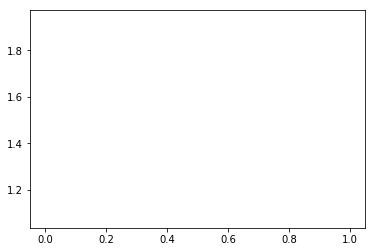

구청장은 교통 수요 증가를 가져오는 도로 건설 등 도로 공급 위주의 교통투자정책을 지양하고, 수송체계 전반을 에너지 효율이 높은 대중교통 중심의 체계로 개선하기 위하여 노력하여야 한다.<eos>                                                                         
구렁장은 가종ᄀ수웡종가를 가정ᅦᆫᅳᆫ 고로 곤걸 그ᄅᄒ고로 고ᄅ갈 귀후에 고소 오 ᅡ ᅥᆼ후ᄒ을 기워 하고  구송이 ᅦ 언가ᄀ ᅦᆯ 위허 ᅵ 아셔ᄅ이 애ᄅ은 오후ᄋ와호 ᄋ구ᄉ이 으 우고 ᅩ 고선 ᅡ기 이하여ᄋ개롱아겨에 간다ᄀ<eos><eos>ᄉᄌᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀᄀ
성도는 회개와 기도, 절제와 금식, 깊은 명상과 경건 생활을 통해 수난의 길을 걸어가신 주님을 기억하며 그 은혜를 감사할 수 있어야 한다.<eos>                                                                                                                                         
겅송ᅳᆫ 재개의 기초  얼 ᅥ에 금식ᄋ 긴은 궁상과 긍선 생핼을 공해ᄋ순ᅳᆼ ᅳ 그ᄀ은 깃어 ᅡ ᅵᆫ 준ᅵᆫ을 ᄀ

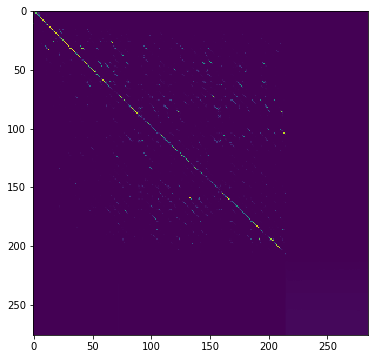

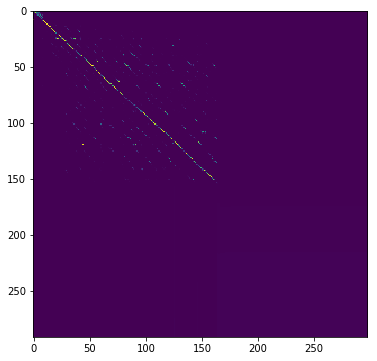

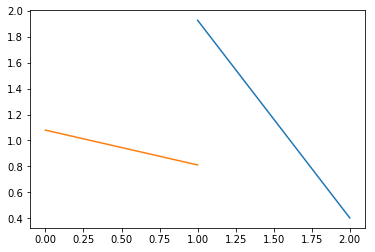

심의위원회는 위원장이 필요하다고 인정하는 경우와 구청장의 회의소집 요구가 있을 때에 위원장이 소집하며 재적위원 과반수의 출석으로 개의하고, 출석위원 과반수의 찬성으로 의결한다.<eos>                                                                              
이ᄆ의워원회는 위원정이 결요하도뎌 귀ᄋ악하드  경약ᅡᆨ개바ᄒ아 줘ᄋ와바각ᅥᄋᄋ귀바가 귀ᄇ압ᄀ애의ᄀ여변허ᄀ의ᄋ애바ᄀ안ᅡ 구박으원 과반서궈 외ᄇ각으로 개바간ᅧ  개ᄇ각의원 과반서궈ᄋ외ᄇ각의로 규격아  ᅢᄋ<eos>ᄀᄀ<eos>                                                                           
민간환경단체 등 구민단체는 구민의 환경보전 실천의지를 높이기 위한 홍보와 환경오염 감시 등의 환경보전활동에 노력하여야 한다.<eos>                                                                                                                                               
긴간환경단체 등 구민단체는 수민다ᄌ뫈경보전 실엔베전ᅩᆯᄌ승벤ᅩᆯ윈ᅡᆫ 홍보완완경버좐ᄋ안시 등

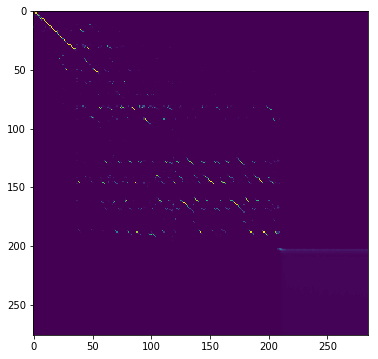

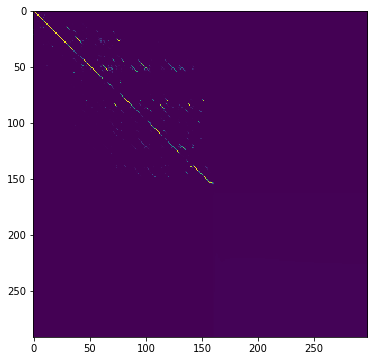

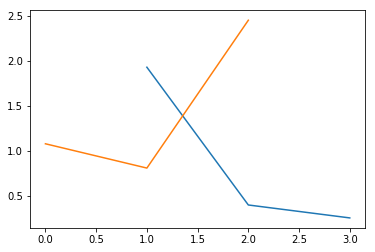

헌장부서의 장은 필요하다고 인정하는 경우에는 고객의 요구사항과 서비스를 제공하는 담당공무원의 애로사항 및 개선의견을 반영하여 헌장을 개정하는 등의 필요한 조치를 하여야 한다.<eos>                                                                           
언장부서에 장은 필요하다고 인정하는 경우에는 격ᅢᄀ에 위구사하ᄂ여 어비스를 제객아든 감당과  ᅮ엔으 쇼구사항ᄀ좇 개가ᄅ으 ᅪ  ᅭᆫ 젬당하느 새ᄅ잉을 조징하는 당에 필으하ᄂᄋ메치를 자영ᅣ 한당<eos>ᅵ,ᄋ                                                                        
조선은 청나라와 두 번의 전쟁에서 패배하며 청과 조공관계를 맺을 수밖에 없었지만, 조선이 문화적으로 중국보다 우월하다고 믿고 있었다.<eos>                                                                                                                                              
초성 ᅣᆯᄒ찬월ᅩ?ᅣ.<eos>ᅳᄋ<eos>ᅣᅣ ᅣᆯ<eos>ᅡᆻ다.<eos>ᅣ.ᅣ.<eos>ᅣ.ᅣᆯᅣ.ᅣ.<eos>ᅣ  ᅣᆫ<eos>ᅡᅡᅡ?.ᅳ. ᅩ.ᅩ. <eos>ᅣ  ᅣᆯᄒ<eos>ᅡ.ᅣ. 

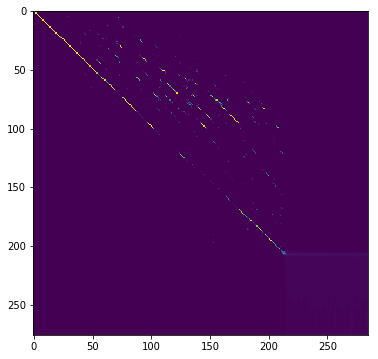

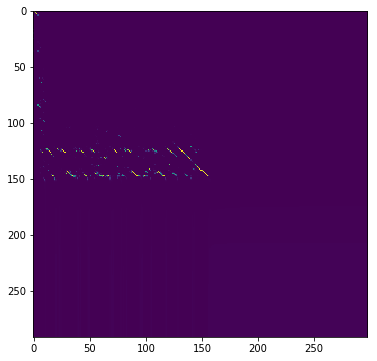

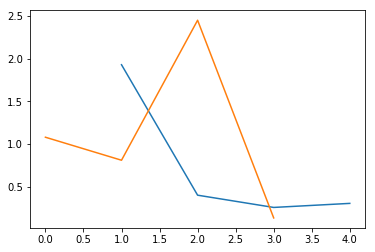

아기 엄마들은 아토피 등의 위험 때문에 시중의 아무 턱받이나 사용하기가 곤란했는데 프로그램 수강생들이 직접 만든 친환경적 턱받이를 선물로 받게 되었다며 큰 호응을 보냈다.<eos>                                                                                
아기 없마들인 아토피 등에 위험 때문에 시중에 아무 턱바ᄌ이나 사용하기가 골란핸는데 프로그램 수강생들이 직접 만든 친환경적 턱바ᄌ이를 선물로 받게 되었다며 큰 호응을 보냈다ᄆ<eos>ᅧᄋᄋᄋᄋ                                        ᄋ   ᄋ     ᄋ         ᄋ ᄋ            
대불튀기는 대보름날 새벽이 되면 자기 집 마당에서 대나무를 태우는데, 이때에 나는 소리에 때문에 집안의 잡귀가 놀라서 달아나게 하는 풍속이다.<eos>                                                                                                                                           
대불 ᅢ이는 대보름날 새벽이 되면 자기 집 맏ᅡᆼ에서 대남ᅮ를 태운ᅳᆫ데  이대에 나는 소리에 때문에 집안에 자

KeyboardInterrupt: ignored

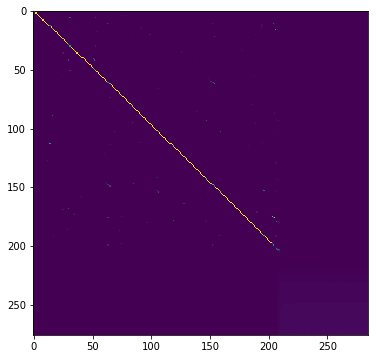

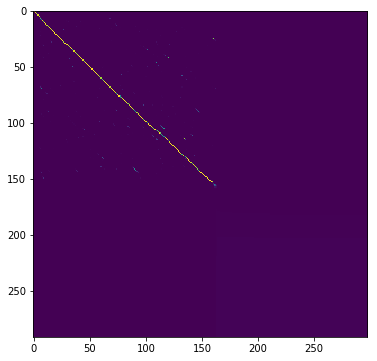

In [15]:
# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'eumun-to-eumjul'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

try:
    loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
    loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
except:
    print("Loading Failed")

EPOCH = 3 * 60 * 4
    
# Load model if model weights already exists
try:
    net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
except:
    print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    train_batch_loader.initialize_batch()
    loss_list_train = list()
    
    while train_batch_loader.end_flag == False:
        eumjul_batch, eumun_batch, eumun_loss_mask = train_batch_loader.get_batch()
        pred_tensor, attention_tensor, loss = net.train(eumun_batch.to(device), eumjul_batch.to(device), eumun_loss_mask.to(device))        
        loss_list_train.append(loss)

    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    eval_batch_loader.initialize_batch()
    loss_list_eval = list()
    
    while eval_batch_loader.end_flag == False:
        eumjul_batch_, eumun_batch_, eumun_loss_mask = eval_batch_loader.get_batch()
        pred_tensor_, attention_tensor_, loss = net.evaluate(eumun_batch_.to(device), eumjul_batch_.to(device), eumun_loss_mask.to(device))        
        loss_list_eval.append(loss)

    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    plt.figure()
    plt.plot(loss_history_train)
    plt.plot(loss_history_eval)
    plt.show()
    
    sentence = tokenizer.num2word(eumun_batch[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    _, pred_token = pred_tensor[0].max(-1)
    sentence = tokenizer.num2word(pred_token.detach())
    print(''.join(sentence))
    
    sentence = tokenizer.num2word(eumjul_batch[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    plt.figure(figsize = (6, 6))
    plt.imshow(attention_tensor[0].detach().cpu().numpy())
    plt.show
    
    sentence = tokenizer.num2word(eumun_batch_[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    _, pred_token = pred_tensor_[0].max(-1)
    sentence = tokenizer.num2word(pred_token.detach())
    print(''.join(sentence))
    
    sentence = tokenizer.num2word(eumjul_batch_[0].detach().cpu().numpy().astype(int))
    print(''.join(sentence))

    plt.figure(figsize = (6, 6))
    plt.imshow(attention_tensor_[0].detach().cpu().numpy())
    plt.show

    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)
    

    print("-------------------------------------------------------------------------------------------------------")

In [20]:
loss_history_train


[nan,
 1.9283865360831167,
 0.40222239467711174,
 0.25887658695597215,
 0.30624383543135675]